# Pendulum Experiments for DS-VAE

This notebook trains two separate models: 

1. $(l \rightarrow \hat{\theta}_{undamped})$, 
2. ($\hat{\theta}_{undamped}, b) \rightarrow \hat{\theta}_{damped}$ 
3. ($\hat{\theta}_{damped}, z) \rightarrow \hat{\theta}_{damped mass}$

Here, we want to first learn to reconstruct the angular displacement for a pendulum simulator that has no friction. Then we want to do the same for a pendulum with friction and mass 1. Then we want to learn a generative model of mass with a VAE.

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import math
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from plotting_functions import plot_random_test_point, plot_thetas, plot_theta
np.random.seed(0)
import argparse 
from tqdm import tqdm
from pytorch_lightning import Trainer

torch.manual_seed(0);

# Prepare Datasets and Model Parameters

In [2]:
L_ARRAY = np.asarray(np.arange(1,3.1,.1),dtype=np.float32)
B_ARRAY = np.asarray(np.arange(.1,2.1,.1),dtype=np.float32)
M_ARRAY = [.1, .5, 1.0, 1.5, 2.0]

BATCH_SIZE = 50
OUT = 100

In [3]:
def generateData(L, m, b, out=OUT):
    st = 0
    et = OUT // 10
    ts = 0.1
    g = 9.8

    def sim_pen_eq(t, theta):
        dtheta2_dt = (-b / m) * theta[1] + (-g / L) * np.sin(theta[0])
        dtheta1_dt = theta[1]
        return [dtheta1_dt, dtheta2_dt]

    def sim():
        theta1_ini = 0
        theta2_ini = 3
        theta_ini = [theta1_ini, theta2_ini]
        t_span = [st, et + ts]
        t = np.arange(st, et + ts, ts)
        sim_points = len(t)
        l = np.arange(0, sim_points, 1)

        theta12 = solve_ivp(sim_pen_eq, t_span, theta_ini, t_eval=t)
        theta1 = theta12.y[0, :]
        theta2 = theta12.y[1, :]
        return theta1[:-1]

    return sim()

In [4]:
def make_data(datasize, l=[1.0], m=[1], b=[0], seed=0):
    X = []
    L = []
    M = []
    B = []
    for i in range(datasize):
        l_ = np.random.choice(l)
        m_ = np.random.choice(m)
        b_ = np.random.choice(b)
        L.append([l_])
        M.append([m_])
        B.append([b_])
        X.append(generateData(l_, m_, b_))
    return np.asarray(X), np.asarray(L), np.asarray(M), np.asarray(B),

In [5]:
X, L, M, B = make_data(500, l=L_ARRAY, m=[1], b=[0], seed=0)

In [6]:
from datasets import SimplePendulumDataset

train_set_sp = SimplePendulumDataset(torch.from_numpy(L).float(), torch.from_numpy(X).float())
train_loader_sp = torch.utils.data.DataLoader(train_set_sp, batch_size=BATCH_SIZE, shuffle=True)

# Train a model to learn a simple pendulum: $(l \rightarrow \theta_{undamped}) $

In [7]:
from models.simulator_model import SimulatorModel

simulator_model = SimulatorModel(1, OUT, train_loader=train_loader_sp, learning_rate=1e-3)
# Train with pytorch lightning module
trainer = Trainer(min_epochs=400, max_epochs=400, gpus=1, logger=False, early_stop_callback=None)    
trainer.fit(simulator_model);

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
           Name     Type Params
0     loss_func  MSELoss    0  
1           fc1   Linear  800  
2           fc2   Linear  160 K
3  theta1_layer   Linear   40 K


Epoch 400: 100%|██████████| 10/10 [00:00<00:00, 192.13batch/s, batch_idx=9, gpu=0, loss=0.000]


l:  1.399999976158142


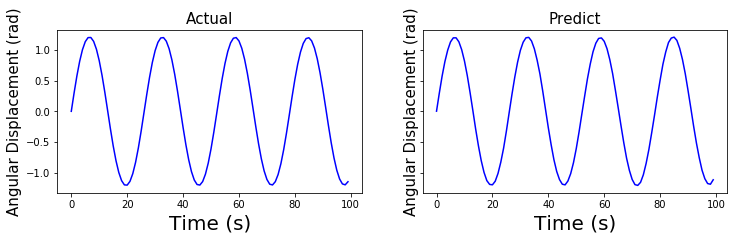

ls: [2.         2.05263158 2.10526316 2.15789474 2.21052632 2.26315789
 2.31578947 2.36842105 2.42105263 2.47368421 2.52631579 2.57894737
 2.63157895 2.68421053 2.73684211 2.78947368 2.84210526 2.89473684
 2.94736842 3.        ]


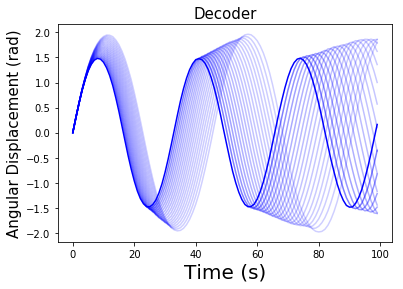

In [8]:
device = 0

simulator_model.eval()
example_set = train_set_sp

idx = np.random.choice(range(len(train_set_sp)))
l, theta_undamped = example_set[idx][0].to(device), example_set[idx][1].to(device)
print("l: ", l.item())
predict_thetas = simulator_model(l.unsqueeze(0))

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,3))
ax = axes[0]
plot_theta(range(100), theta_undamped.detach().cpu().numpy(), ax=ax, title="Actual", alpha=1)
ax = axes[1]
plot_theta(range(100),  predict_thetas[0].detach().cpu().numpy(), ax=ax, title="Predict", alpha=1)
plt.show()
l = torch.from_numpy(np.asarray([2.00])).float().to(device)
predict_thetas = simulator_model(l.unsqueeze(0))
fig, ax = plt.subplots()
for i, l in enumerate(np.linspace(2, 3, 20)):
    l = torch.from_numpy(np.asarray([l])).float().to(device)
    predict_thetas = simulator_model(l.unsqueeze(0))
    plot_theta(range(100), predict_thetas[0].detach().cpu().numpy(), ax=ax, title="Decoder",  alpha=1/(1+i**(1/2)))
print("ls: " + str(np.linspace(2, 3, 20)))

# Train a model to learn friction: ($\hat{\theta}_{undamped}, b) \rightarrow \hat{\theta}_{damped}$

In [9]:
X, L, M, B = make_data(2000, l=L_ARRAY, m=[1], b=B_ARRAY, seed=1)

In [10]:
from datasets import FrictionPendulumDataset

train_set_fp = FrictionPendulumDataset(torch.from_numpy(L).float(), torch.from_numpy(B).float(), torch.from_numpy(X).float())
train_loader_fp = torch.utils.data.DataLoader(train_set_fp, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
from models.friction_model import FrictionModel

friction_model = FrictionModel(1 + OUT, OUT, train_loader_fp, simulator_model, learning_rate=1e-3)
# Train with pytorch lightning module
trainer = Trainer(min_epochs=400, max_epochs=400, gpus=1, logger=False, early_stop_callback=None)    
trainer.fit(friction_model);

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                           Name            Type Params
0               simulator_model  SimulatorModel  201 K
1     simulator_model.loss_func         MSELoss    0  
2           simulator_model.fc1          Linear  800  
3           simulator_model.fc2          Linear  160 K
4  simulator_model.theta1_layer          Linear   40 K
5                     loss_func         MSELoss    0  
6                           fc1          Linear   40 K
7                           fc2          Linear  160 K
8                  theta1_layer          Linear   40 K


Epoch 400: 100%|██████████| 40/40 [00:00<00:00, 132.95batch/s, batch_idx=39, gpu=0, loss=0.000]


l:  3.0
b:  1.7000000476837158


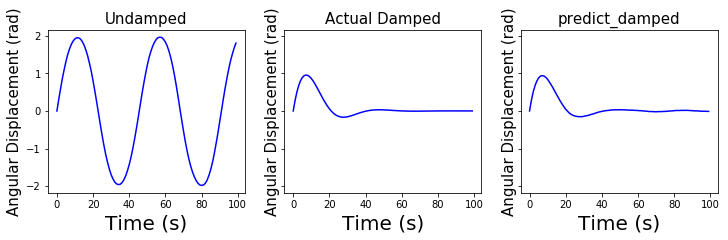

bs: [0.1        0.11836735 0.13673469 0.15510204 0.17346939 0.19183673
 0.21020408 0.22857143 0.24693878 0.26530612 0.28367347 0.30204082
 0.32040816 0.33877551 0.35714286 0.3755102  0.39387755 0.4122449
 0.43061224 0.44897959 0.46734694 0.48571429 0.50408163 0.52244898
 0.54081633 0.55918367 0.57755102 0.59591837 0.61428571 0.63265306
 0.65102041 0.66938776 0.6877551  0.70612245 0.7244898  0.74285714
 0.76122449 0.77959184 0.79795918 0.81632653 0.83469388 0.85306122
 0.87142857 0.88979592 0.90816327 0.92653061 0.94489796 0.96326531
 0.98163265 1.        ]


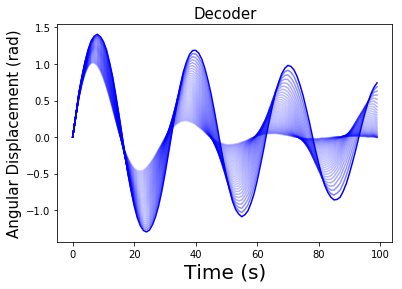

In [12]:
device = 0

friction_model.eval()
example_set = train_set_fp

idx = np.random.choice(range(1000))
l, b, theta_damped = example_set[idx][0].to(device), example_set[idx][1].to(device), example_set[idx][2].to(device)
print("l: ", l.item())
print("b: ", b.item())
predict_thetas = simulator_model(l.unsqueeze(0))
# predict_damped = friction_model(l.unsqueeze(0), b.unsqueeze(0))
predict_damped = friction_model(l.unsqueeze(0), b.unsqueeze(0))
# predict_damped = predict_thetas + predict_residuals

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,3))
ax = axes[0]
plot_theta(range(100), predict_thetas[0].detach().cpu().numpy(), ax=ax, title="Undamped", alpha=1)
ax = axes[1]
plot_theta(range(100), theta_damped.detach().cpu().numpy(), ax=ax, title="Actual Damped",  alpha=1)
ax = axes[2]
plot_theta(range(100), predict_damped[0].detach().cpu().numpy(), ax=ax, title="predict_damped", alpha=1)
plt.show()
print("bs: " + str(np.linspace(.1, 1, 50)))
fig, ax = plt.subplots()
l = torch.from_numpy(np.asarray([2.00])).float().to(device)
for i, b in enumerate(np.linspace(.1, 1, 50)):
    b = torch.from_numpy(np.asarray([b])).float().to(device)
    predict_damped = friction_model(l.unsqueeze(0), b.unsqueeze(0))
    plot_theta(range(100), predict_damped[0].detach().cpu().numpy(), ax=ax, title="Decoder",  alpha=1/(1+i**(1/2)))

# Train a VAE to learn about mass ($\hat{\theta}_{damped}, z) \rightarrow \hat{\theta}_{damped mass}$

In [13]:
X, L, M, B = make_data(l=L_ARRAY, m=M_ARRAY, b=B_ARRAY, datasize=5000, seed=2)

In [14]:
from datasets import MassPendulumDataset

train_set_mp = MassPendulumDataset(torch.from_numpy(L).float(), torch.from_numpy(B).float(), torch.from_numpy(M).float(), torch.from_numpy(X).float())
train_loader_mp = torch.utils.data.DataLoader(train_set_mp, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
from models.mass_model import MassVAE

mass_vae = MassVAE(1, OUT, train_loader_mp, friction_model, learning_rate=1e-3, beta1=.9, beta2=.999, likelihood_var=.25, batch_norm=False)
# Train with pytorch lightning module
trainer = Trainer(min_epochs=200, max_epochs=200, gpus=1, logger=False, early_stop_callback=None)    
trainer.fit(mass_vae);

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                           Name            Type Params
0                                friction_model   FrictionModel  442 K
1                friction_model.simulator_model  SimulatorModel  201 K
2      friction_model.simulator_model.loss_func         MSELoss    0  
3            friction_model.simulator_model.fc1          Linear  800  
4            friction_model.simulator_model.fc2          Linear  160 K
5   friction_model.simulator_model.theta1_layer          Linear   40 K
6                      friction_model.loss_func         MSELoss    0  
7                            friction_model.fc1          Linear   40 K
8                            friction_model.fc2          Linear  160 K
9                   friction_model.theta1_layer          Linear   40 K
10                                      fc1_enc          Linear   40 K
11                                        fc_mu          Linear  401 

Epoch 200: 100%|██████████| 100/100 [00:01<00:00, 68.72batch/s, batch_idx=99, gpu=0, loss=-44.471, m_kld=1.72, m_nll=-46.4]


l:  2.5
b:  1.7999999523162842
m:  0.10000000149011612
tensor([[-1.5194]], device='cuda:0', grad_fn=<AddmmBackward>)


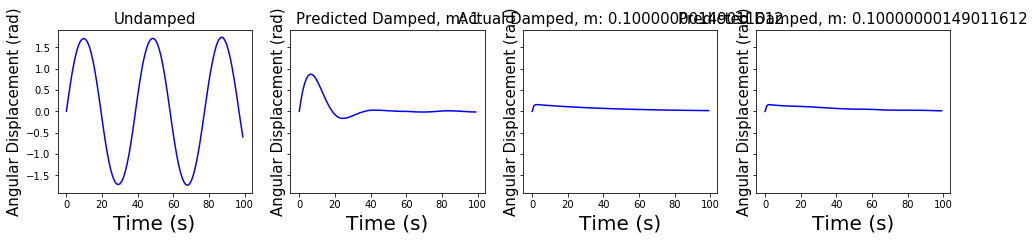

In [16]:
device = 0
mass_vae.eval()
example_set = train_set_mp

idx = np.random.choice(range(1000))
l, b, m, theta_damped_mass = example_set[idx][0].to(device), example_set[idx][1].to(device), example_set[idx][2].to(device), example_set[idx][3].to(device)
print("l: ", l.item())
print("b: ", b.item())
print("m: ", m.item())
predict_thetas = simulator_model(l.unsqueeze(0))
predict_damped = friction_model(l.unsqueeze(0), b.unsqueeze(0))
predict_damped_mass, mu, var = mass_vae(l.unsqueeze(0), b.unsqueeze(0), theta_damped_mass.unsqueeze(0))
print(mu)

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,3))
ax = axes[0]
plot_theta(range(100), predict_thetas[0].detach().cpu().numpy(), ax=ax, title="Undamped", alpha=1)
ax = axes[1]
plot_theta(range(100), predict_damped[0].detach().cpu().numpy(), ax=ax, title="Predicted Damped, m: 1",  alpha=1)
ax = axes[2]
plot_theta(range(100), theta_damped_mass.detach().cpu().numpy(), ax=ax, title="Actual Damped, m: {}".format(m.item()),  alpha=1)
ax = axes[3]
plot_theta(range(100), predict_damped_mass[0].detach().cpu().numpy(), ax=ax, title="Predicted Damped, m: {}".format(m.item()),  alpha=1);

# Fix b and l, change z

l:  2.200000047683716
b:  1.600000023841858
m:  1.0
mss: [0.1, 0.5, 1.0, 1.5, 2.0]
zs: [ 1.          0.57894737  0.05263158 -0.47368421 -1.        ]


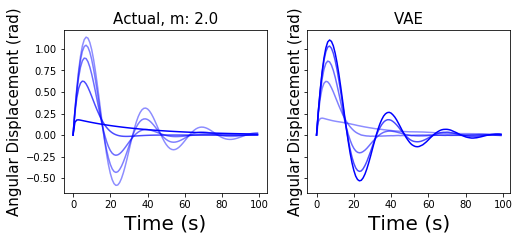

In [17]:
mass_vae.eval()
example = make_data(1, l=L_ARRAY, m=[1], b=B_ARRAY)
l = torch.from_numpy(np.asarray(example[1])).float().to(device)
m = torch.from_numpy(np.asarray(example[2])).float().to(device)
b = torch.from_numpy(np.asarray(example[3])).float().to(device)
print("l: ", l.item())
print("b: ", b.item())
print("m: ", m.item())
predict_theta_damp = friction_model(l, b)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8,3))
print("mss: " + str(M_ARRAY))
for i, m in enumerate(M_ARRAY):
    example = make_data(1, l=[l], m=[m], b=[b])
    plot_theta(range(100), example[0][0], ax=axes[0], title="Actual, m: {}".format(m), alpha=1/(i+1)**(1/2))
    
z_guess = -1*((1 - (-1))*((np.asarray(M_ARRAY) - np.min(M_ARRAY))/(np.max(M_ARRAY) - np.min(M_ARRAY))) - 1)
print("zs: " + str(z_guess))
for i, z in enumerate(z_guess):
    z = torch.from_numpy(np.asarray([z])).float().to(device)
    predict_damped_mass = mass_vae.decode(predict_theta_damp, z.unsqueeze(0))
    plot_theta(range(100), predict_damped_mass[0].detach().cpu().numpy(), ax=axes[1], title="VAE", alpha=1/(i+1)**(1/2))

# Plot correlation between z_mu and m

In [18]:
dataset_size = 500
fine_m_array = np.linspace(0.1, 2.0, 30)
X, L, M, B = make_data(l=L_ARRAY, m=fine_m_array, b=B_ARRAY, datasize=dataset_size, seed=3)
example_set = MassPendulumDataset(torch.from_numpy(L).float(), torch.from_numpy(B).float(), torch.from_numpy(M).float(), torch.from_numpy(X).float())

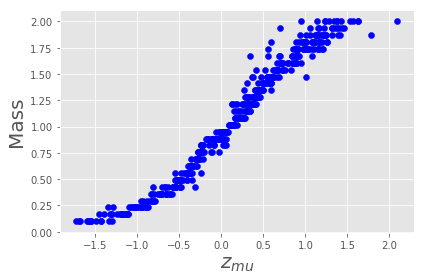

In [19]:
import tikzplotlib
plt.style.use("ggplot")

device = 0
mass_vae.eval()
fig, ax = plt.subplots()
ax.set_ylabel("Mass", size = 20)
ax.set_xlabel("$z_{mu}$", size = 20)
mus = []
ms = []
for i in range(dataset_size):
    l, b, m, theta_damped_mass = example_set[i][0].to(device), example_set[i][1].to(device), example_set[i][2].to(device), example_set[i][3].to(device)
    predict_thetas = simulator_model(l.unsqueeze(0))
    predict_damped = friction_model(l.unsqueeze(0), b.unsqueeze(0))
    predict_damped_mass, mu, var = mass_vae(l.unsqueeze(0), b.unsqueeze(0), theta_damped_mass.unsqueeze(0))
    mus.append([mu.item()])
    ms.append([m.item()])

ax.scatter(mus, ms, color="blue")
    
plt.grid(True)
plt.tight_layout()
# tikzplotlib.save("regression_plot_z.tex")
plt.savefig('pendulum_regression_plot_z.pdf', dpi=300)

# KNN regression to get a value of z for m

In [20]:
from sklearn.neighbors import KNeighborsRegressor

mus_array = np.asarray(mus)
ms_array = np.asarray(ms)
clf = KNeighborsRegressor(n_neighbors=10)
clf.fit(ms_array, mus_array)

z_change = []
for m in M_ARRAY:
    z = clf.predict([[m]])
    z_change.append(z[0][0])

# Fix b and z, change l (VAE)

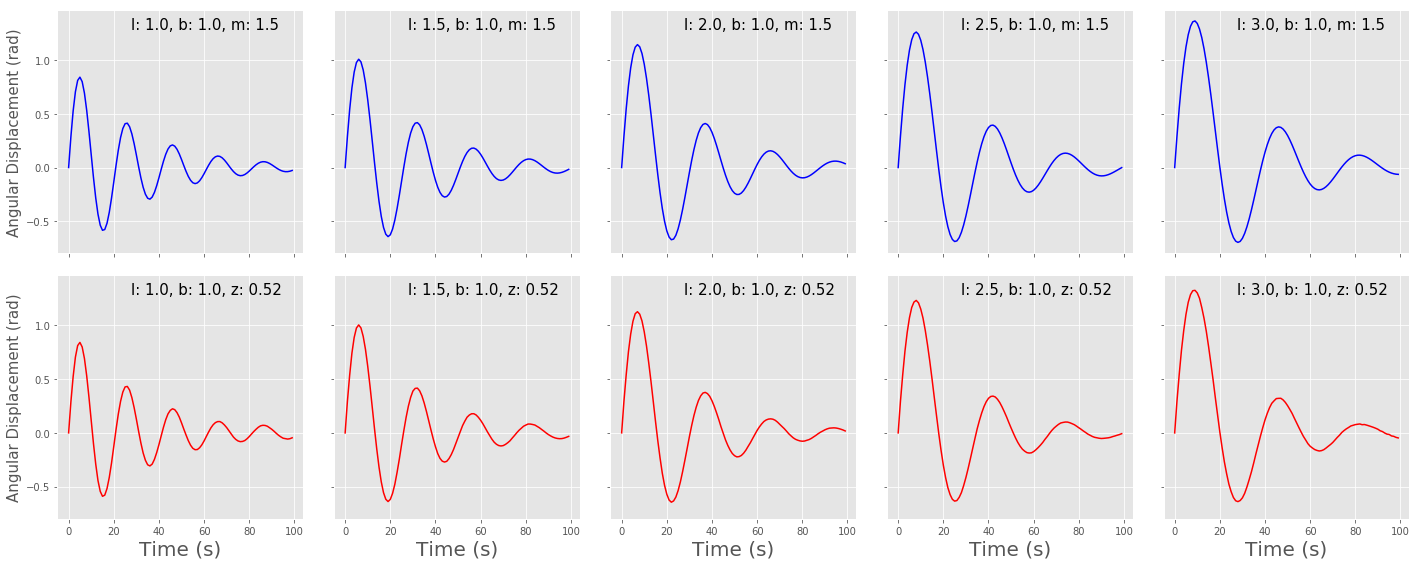

In [44]:
# mass_vae.eval()
l_change = np.linspace(L_ARRAY[0], L_ARRAY[-1], 5)
fig, axes = plt.subplots(nrows=2, ncols=len(l_change), sharex=True, sharey=True, figsize=(20,8))
for i, l in enumerate(l_change):
    b = 1
    z = z_change[3] # mass = 1
    l = torch.from_numpy(np.asarray([l])).float().to(device)
    b = torch.from_numpy(np.asarray([b])).float().to(device)
    z = torch.from_numpy(np.asarray([z])).float().to(device)
    predict_theta_damp = friction_model(l.unsqueeze(0), b.unsqueeze(0))
    if i == 0:
        do_y_label = True
    else:
        do_y_label = False
    predict_damped_mass = mass_vae.decode(predict_theta_damp, z.unsqueeze(0))
    l = round(l.item(),2)
    b = round(b.item(),2)
    z = round(z.item(),2)
    m = 1.5
    example = make_data(1, l=[l], m=[m], b=[b])
    plot_theta(range(100), example[0][0], ax=axes[0, i], title="Length Traversal".format(l, b, m), alpha=1, do_y_label=do_y_label, do_title=False, do_x_axis=False)
    plot_theta(range(100), predict_damped_mass[0].detach().cpu().numpy(), ax=axes[1, i], title=" l: {}, b: {}, z: {}".format(l, b, z), alpha=1, do_y_label=do_y_label, do_title=False, color="red")
    
    axes[0, i].annotate('l: {}, b: {}, m: {}'.format(l, b, m), xy=(3, 1),  xycoords='data',
            xytext=(0.3, 0.97), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=15
            )
    axes[1, i].annotate('l: {}, b: {}, z: {}'.format(l, b, z), xy=(3, 1),  xycoords='data',
            xytext=(0.3, 0.97), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=15
            )
    
plt.tight_layout()
plt.savefig('pendulum_l_traversal.pdf', dpi=300)

# Fix l and z, change b (VAE)

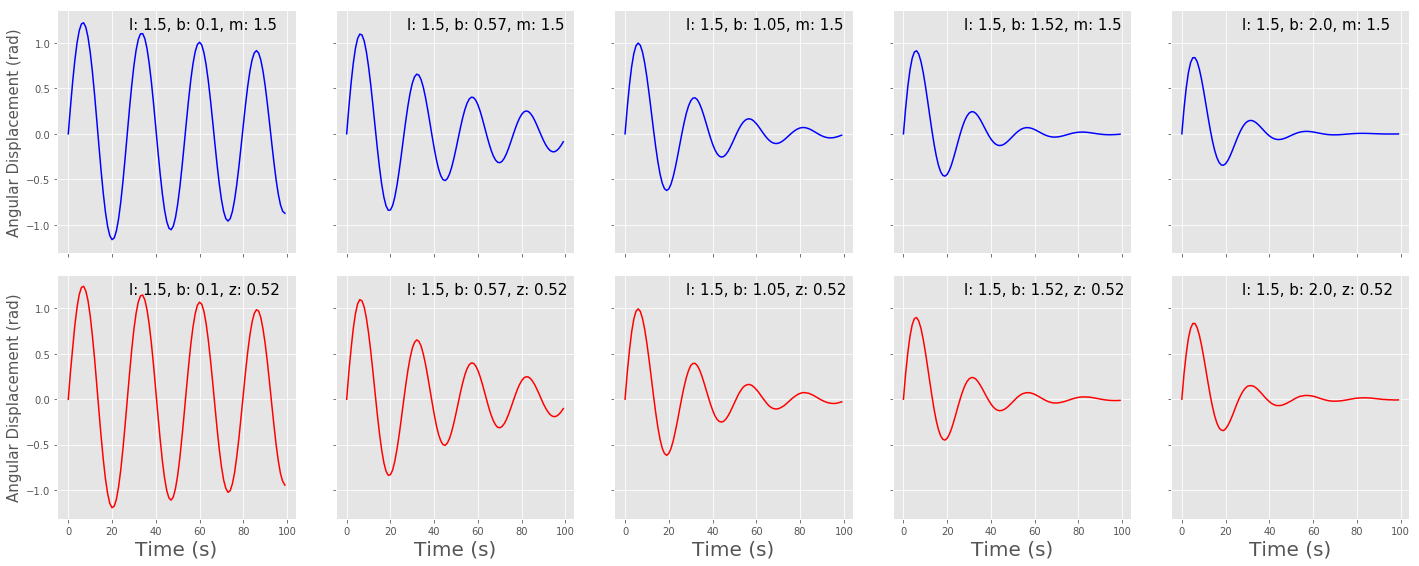

In [46]:
# mass_vae.eval()
b_change = np.linspace(B_ARRAY[0], B_ARRAY[-1], 5)
fig, axes = plt.subplots(nrows=2, ncols=len(b_change), sharex=True, sharey=True, figsize=(20,8))
for i, b in enumerate(b_change):
    l = 1.5
    z = z_change[3] # mass = 1
    l = torch.from_numpy(np.asarray([l])).float().to(device)
    b = torch.from_numpy(np.asarray([b])).float().to(device)
    z = torch.from_numpy(np.asarray([z])).float().to(device)
    predict_theta_damp = friction_model(l.unsqueeze(0), b.unsqueeze(0))
    if i == 0:
        do_y_label = True
    else:
        do_y_label = False
    predict_damped_mass = mass_vae.decode(predict_theta_damp, z.unsqueeze(0))
    l = round(l.item(),2)
    b = round(b.item(),2)
    z = round(z.item(),2)
    m = 1.5
    example = make_data(1, l=[l], m=[m], b=[b])
    plot_theta(range(100), example[0][0], ax=axes[0, i], title="Damping Traversal".format(l, b, m), alpha=1, do_y_label=do_y_label, do_title=False, do_x_axis=False)
    plot_theta(range(100), predict_damped_mass[0].detach().cpu().numpy(), ax=axes[1, i], title=" l: {}, b: {}, z: {}".format(l, b, z), alpha=1, do_y_label=do_y_label, do_title=False, color="red")
    
    axes[0, i].annotate('l: {}, b: {}, m: {}'.format(l, b, m), xy=(3, 1),  xycoords='data',
            xytext=(0.3, 0.97), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=15
            )
    axes[1, i].annotate('l: {}, b: {}, z: {}'.format(l, b, z), xy=(3, 1),  xycoords='data',
            xytext=(0.3, 0.97), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=15
            )
    
plt.tight_layout()
plt.savefig('pendulum_b_traversal.pdf', dpi=300)

# Fix l and b, change z (VAE)

In [35]:
m_change = np.linspace(M_ARRAY[0], M_ARRAY[-1], 5)

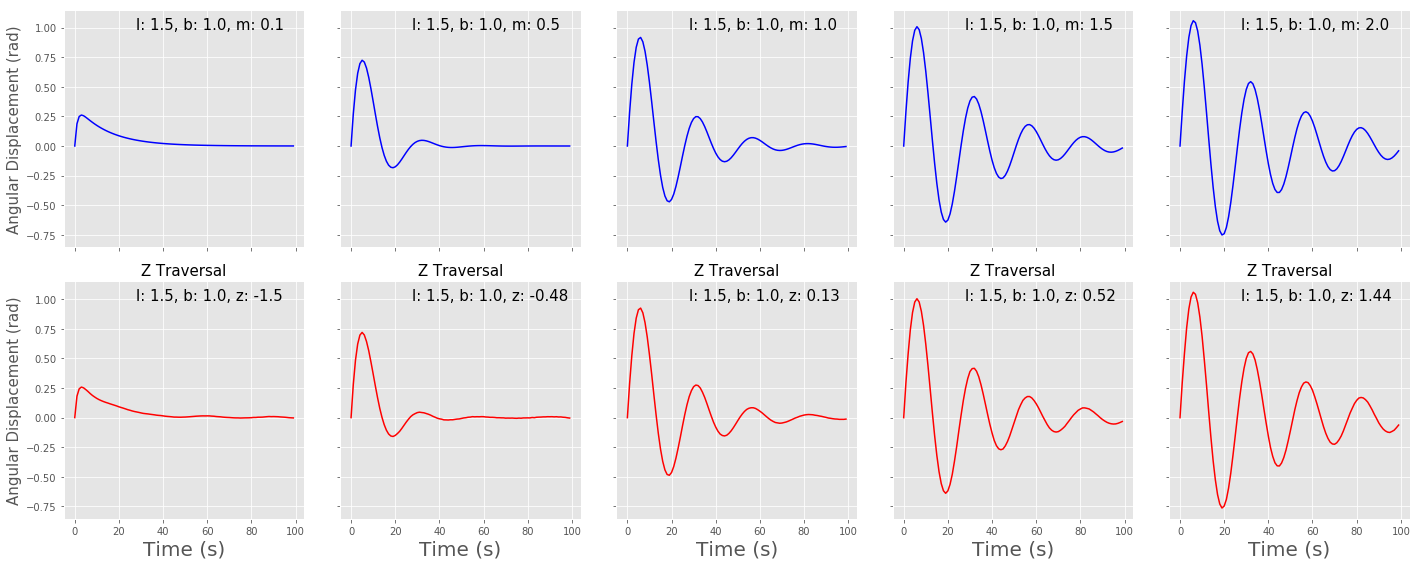

In [48]:
# mass_vae.eval()
fig, axes = plt.subplots(nrows=2, ncols=len(l_change), sharex=True, sharey=True, figsize=(20,8))
m_change = M_ARRAY
for i, (z, m) in enumerate(zip(z_change, m_change)):
    l = 1.5
    b = 1
    l = torch.from_numpy(np.asarray([l])).float().to(device)
    b = torch.from_numpy(np.asarray([b])).float().to(device)
    z = torch.from_numpy(np.asarray([z])).float().to(device)
    predict_theta_damp = friction_model(l.unsqueeze(0), b.unsqueeze(0))
    if i == 0:
        do_y_label = True
    else:
        do_y_label = False
    predict_damped_mass = mass_vae.decode(predict_theta_damp, z.unsqueeze(0))
    l = round(l.item(),2)
    b = round(b.item(),2)
    z = round(z.item(),2)
    example = make_data(1, l=[l], m=[m], b=[b])
    m = round(m, 2)
    plot_theta(range(100), example[0][0], ax=axes[0, i], title="Mass Traversal".format(l, b, m), alpha=1, do_y_label=do_y_label, do_title=False, do_x_axis=False)
    plot_theta(range(100), predict_damped_mass[0].detach().cpu().numpy(), ax=axes[1, i], title="Z Traversal".format(l, b, z), alpha=1, do_y_label=do_y_label, do_title=True, color="red")
    
    axes[0, i].annotate('l: {}, b: {}, m: {}'.format(l, b, m), xy=(3, 1),  xycoords='data',
            xytext=(0.3, 0.97), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=15
            )
    axes[1, i].annotate('l: {}, b: {}, z: {}'.format(l, b, z), xy=(3, 1),  xycoords='data',
            xytext=(0.3, 0.97), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=15
            )
    
plt.tight_layout()
plt.savefig('pendulum_z_traversal.pdf', dpi=300)

l:  1.899999976158142
b:  0.8999999761581421
m:  2.0
tensor([[1.5130]], device='cuda:0', grad_fn=<AddmmBackward>)


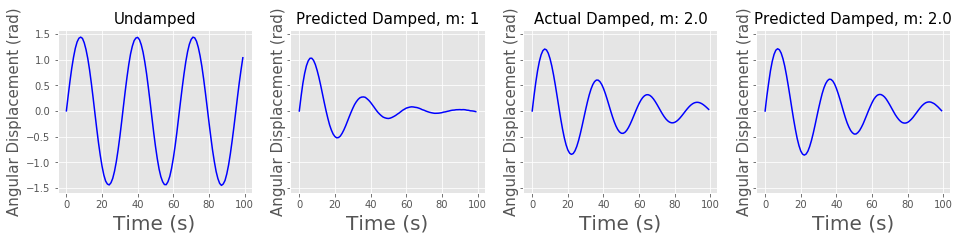

In [49]:
device = 0
mass_vae.eval()
example_set = train_set_mp

idx = np.random.choice(range(1000))
l, b, m, theta_damped_mass = example_set[idx][0].to(device), example_set[idx][1].to(device), example_set[idx][2].to(device), example_set[idx][3].to(device)
print("l: ", l.item())
print("b: ", b.item())
print("m: ", m.item())
predict_thetas = simulator_model(l.unsqueeze(0))
predict_damped = friction_model(l.unsqueeze(0), b.unsqueeze(0))
predict_damped_mass, mu, var = mass_vae(l.unsqueeze(0), b.unsqueeze(0), theta_damped_mass.unsqueeze(0))
print(mu)

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,3))
ax = axes[0]
plot_theta(range(100), predict_thetas[0].detach().cpu().numpy(), ax=ax, title="Undamped", alpha=1)
ax = axes[1]
plot_theta(range(100), predict_damped[0].detach().cpu().numpy(), ax=ax, title="Predicted Damped, m: 1",  alpha=1)
ax = axes[2]
plot_theta(range(100), theta_damped_mass.detach().cpu().numpy(), ax=ax, title="Actual Damped, m: {}".format(m.item()),  alpha=1)
ax = axes[3]
plot_theta(range(100), predict_damped_mass[0].detach().cpu().numpy(), ax=ax, title="Predicted Damped, m: {}".format(m.item()),  alpha=1);

In [137]:
from matplotlib import rc

rc("font", family="serif", size=12)
rc("text", usetex=True)

l = 1.0
b = 0.3
z = 1.44
l_tensor = torch.from_numpy(np.asarray([l])).float().to(device)
b_tensor = torch.from_numpy(np.asarray([b])).float().to(device)
z_tensor = torch.from_numpy(np.asarray([z])).float().to(device)
undamped_theta_pred = simulator_model(l_tensor.unsqueeze(0))
damped_theta_pred = friction_model(l_tensor.unsqueeze(0), b_tensor.unsqueeze(0))
mass_damped_theta_pred = mass_vae.decode(damped_theta_pred, z_tensor.unsqueeze(0))

m = 2.0
undamped_theta = make_data(1, l=[l], m=[1], b=[0])
damped_theta = make_data(1, l=[l], m=[1], b=[b])
mass_damped_theta = make_data(1, l=[l], m=[m], b=[b])


x_ut_pred = l*np.sin(undamped_theta_pred[0].detach().cpu().numpy())
y_ut_pred = -l*np.cos(undamped_theta_pred[0].detach().cpu().numpy())
x_dt_pred = l*np.sin(damped_theta_pred[0].detach().cpu().numpy())
y_dt_pred = -l*np.cos(damped_theta_pred[0].detach().cpu().numpy())
x_mdt_pred = l*np.sin(mass_damped_theta_pred[0].detach().cpu().numpy())
y_mdt_pred = -l*np.cos(mass_damped_theta_pred[0].detach().cpu().numpy())

x_ut = l*np.sin(undamped_theta_pred[0].detach().cpu().numpy())
y_ut = -l*np.cos(undamped_theta_pred[0].detach().cpu().numpy())
x_dt = l*np.sin(damped_theta_pred[0].detach().cpu().numpy())
y_dt = -l*np.cos(damped_theta_pred[0].detach().cpu().numpy())
x_mdt = l*np.sin(mass_damped_theta_pred[0].detach().cpu().numpy())
y_mdt = -l*np.cos(mass_damped_theta_pred[0].detach().cpu().numpy())

offset_1 = -1.5
offset_2 = 1.5



for i in range(len(x_ut)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot([offset_1 - .5, offset_1 + .5],[0,0],color='black')
    ax.plot(offset_1+x_ut[i],y_ut[i],'bo',markersize=12,color='firebrick', label='Undamped Real \n (l={}, b=0, m=1).'.format(l))
    ax.plot([offset_1+0,offset_1+x_ut[i]],[0,y_ut[i]],color='firebrick')
    ax.plot(offset_1+x_dt[i],y_dt[i],'bo',markersize=12,color='royalblue', label='Damped Real \n (l={}, b={}, m=1)'.format(l, b))
    ax.plot([offset_1+0,offset_1+x_dt[i]],[0,y_dt[i]],color='royalblue')
    ax.plot(offset_1+x_mdt[i],y_mdt[i],'bo',markersize=12,color='forestgreen', label='Damped Real \n (l={}, b={}, m={})'.format(l, b, m))
    ax.plot([offset_1+0,offset_1+x_mdt[i]],[0,y_mdt[i]],color='forestgreen')
    
    ax.plot([offset_2 - .5, offset_2 + .5],[0,0],color='black')
    utp_line, = ax.plot(offset_2+x_ut_pred[i],y_ut_pred[i],'bo',markersize=12,color='salmon')
    ax.plot([offset_2+0,offset_2+x_ut_pred[i]],[0,y_ut_pred[i]],color='salmon')
    dtp_line, =  ax.plot(offset_2+x_dt_pred[i],y_dt_pred[i],'bo',markersize=12,color='cornflowerblue')
    ax.plot([offset_2+0,offset_2+x_dt_pred[i]],[0,y_dt_pred[i]],color='cornflowerblue')
    mdtp_line, = ax.plot(offset_2+x_mdt_pred[i],y_mdt_pred[i],'bo',markersize=12,color='limegreen')
    ax.plot([offset_2+0,offset_2+x_mdt_pred[i]],[0,y_mdt_pred[i]],color='limegreen')
    
    ax.set_xlim(-offset_2-l-.75,offset_2+l+.75)
    ax.set_ylim(-l-.5,l+.5)
    ax.set_xticks([],[])
    ax.set_xlabel('x-direction')
    ax.set_ylabel('y-direction')
    #Add first legend:  only labeled data is included
    legend_size = 10
    leg1 = ax.legend(loc='upper left', prop={'size': legend_size})
    # Add second legend for the maxes and mins.
    # leg1 will be removed from figure
    leg2 = ax.legend([utp_line,dtp_line,mdtp_line],["Undamped Predict \n" + r"$L \rightarrow y_0$", "Damped Predict \n" + r"$(b, y_0) \rightarrow y_1$", "Damped Predict \n" + r"$(z, y_1) \rightarrow \theta$"], loc='upper right', prop={'size': legend_size})
    # Manually add the first legend back
    ax.add_artist(leg1)

    filenumber=i
    filenumber=format(filenumber,"05")
    filename="image{}.png".format(filenumber)
    plt.savefig(filename, dpi=300)
    plt.close()

# os.system("ffmpeg -f image2 -r 20 -i image%05d.png -vcodec mpeg4 -y movie.avi")

In [115]:
"Undamped Predict \n" + r"$L \rightarrow y_0$",

('Undamped Predict \n$L \\rightarrow y_0$',)

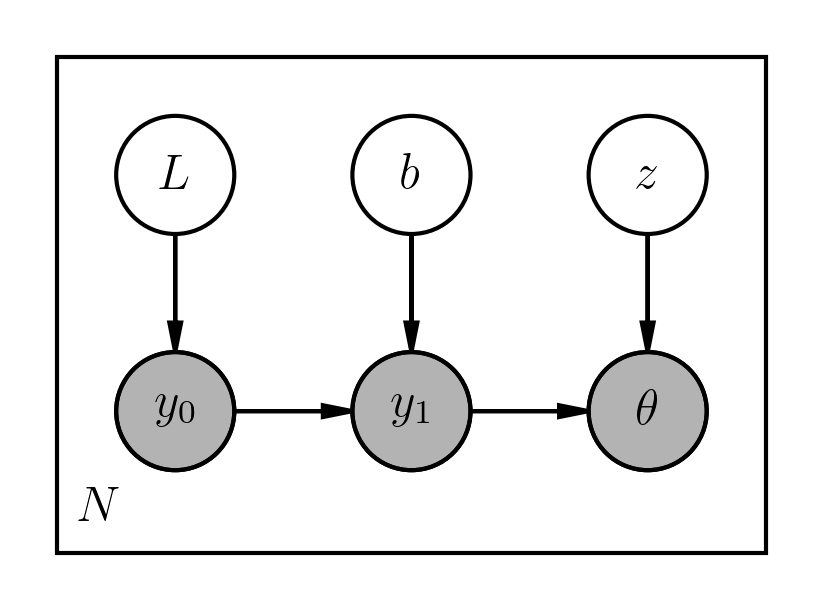

In [106]:
import daft
# Instantiate the PGM.
rc("font", family="serif", size=12)
pgm = daft.PGM()

# Latent variables
pgm.add_node("L", r"$L$", 1, 2)
pgm.add_node("b", r"$b$", 2, 2)
pgm.add_node("z", r"$z$", 3, 2)

# Data.
pgm.add_node("y0", r"$y_0$", 1, 1, observed=True)
pgm.add_node("y1", r"$y_1$", 2, 1, observed=True)
pgm.add_node("theta", r"$\theta$", 3, 1, observed=True)

# Add in the edges.
pgm.add_edge("L", "y0")
pgm.add_edge("y0", "y1")
pgm.add_edge("b", "y1")
pgm.add_edge("y1", "theta")
pgm.add_edge("z", "theta")

# And a plate.
pgm.add_plate([.5, .5, 3, 2], label=r"$N$", shift=-0.1)

# Render and save.
pgm.render(dpi=300)
pgm.savefig("pendulum_pd.pdf", dpi=300)
pgm.savefig("pendulum_pd.png", dpi=300)